# Lab: Image Segmentation with U-Net

In this assignment you will build a U-Net, a type of CNN designed for image segmentation, and use it to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset. 

This type of image classification is called semantic image segmentation. It's similar to object detection, but while in classical object detection, the bounding boxes may include pixels that aren't part of the object, in the semantic image segmentation each pixel in the image gets a class label.  

 The word “semantic” here refers to what is shown, for example the “Car” class is indicated below by the dark blue mask, "Person" is indicated with a red mask. 

<img src="https://github.com/renanaferreira/CAA-repository/blob/main/Lab9/images/carseg.png?raw=true" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

<a name='1'></a>
## 1 - Packages


In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from termcolor import colored
#from test_utils import summary

import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

#import outputs

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# Compare the two inputs
def comparator(learner, instructor):
    for a, b in zip(learner, instructor):
        if tuple(a) != tuple(b):
            print(colored("Test failed", attrs=['bold']),
                  "\n Expected value \n\n", colored(f"{b}", "green"), 
                  "\n\n does not match the input value: \n\n", 
                  colored(f"{a}", "red"))
            raise AssertionError("Error in test") 
    print(colored("All tests passed!", "green"))

# extracts the description of a given model

def summary(model):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        result.append(descriptors)
    return result

def datatype_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += datatype_check(expected_output[key], target_output[key], error)
            except:
                print("Error: {} in variable {}. Got {} but expected type {}".format(error,
                    key, type(target_output[key]), type(expected_output[key])))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try: 
                success += datatype_check(expected_output[i], 
                                         target_output[i], error)
            except:
                print("Error: {} in variable {}, expected type: {}  but expected type {}".format(error,
                            i, type(target_output[i]), type(expected_output[i])))
        if success == len(target_output):
            return 1
        else:
            return 0
    else:
        assert isinstance(target_output, type(expected_output))
        return 1

def equation_output_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += equation_output_check(expected_output[key], target_output[key], error)
            except:
                print("Error: {} for variable {}.".format(error, key))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try: 
                success += equation_output_check(expected_output[i], target_output[i], error)
            except:
                print("Error: {} for variable in position {}.".format(error, i))
        if success == len(target_output):
            return 1
        else:
            return 0
    else:
        if hasattr(target_output, 'shape'):
            np.testing.assert_array_almost_equal(target_output, expected_output)
        else:
            assert target_output == expected_output
        return 1

def shape_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += shape_check(expected_output[key], target_output[key], error)
            except:
                print("Error: {} for variable {}.".format(error, key))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try: 
                success += shape_check(expected_output[i], target_output[i], error)
            except:
                print("Error: {} for variable {}.".format(error, i))
        if success == len(target_output):
            return 1
        else:
            return 0
    else:
        if hasattr(target_output, 'shape'):
            assert target_output.shape == expected_output.shape
        return 1

def single_test(test_cases, target):
    success = 0
    for test_case in test_cases:
        try:
            if test_case['name'] == "datatype_check":
                assert isinstance(target(*test_case['input']), type(test_case["expected"]))
                success += 1
            if test_case['name'] == "equation_output_check":
                assert np.allclose(test_case["expected"], target(*test_case['input']))
                success += 1
            if test_case['name'] == "shape_check":
                assert test_case['expected'].shape == target(*test_case['input']).shape
                success += 1
        except:
            print("Error: " + test_case['error'])

    if success == len(test_cases):
        print("\033[92m All tests passed.")
    else:
        print('\033[92m', success," Tests passed")
        print('\033[91m', len(test_cases) - success, " Tests failed")
        raise AssertionError("Not all tests were passed for {}. Check your equations and avoid using global variables inside the function.".format(target.__name__))

def multiple_test(test_cases, target):
    success = 0
    for test_case in test_cases:
        try:
            target_answer = target(*test_case['input'])                   
            if test_case['name'] == "datatype_check":
                success += datatype_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "equation_output_check":
                success += equation_output_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "shape_check":
                success += shape_check(test_case['expected'], target_answer, test_case['error'])
        except:
            print("Error: " + test_case['error'])

    if success == len(test_cases):
        print("\033[92m All tests passed.")
    else:
        print('\033[92m', success," Tests passed")
        print('\033[91m', len(test_cases) - success, " Tests failed")
        raise AssertionError("Not all tests were passed for {}. Check your equations and avoid using global variables inside the function.".format(target.__name__))

<a name='2'></a>
## 2 - Load and Split the Data

In [9]:
path = ''
image_path = os.path.join(path, '/kaggle/input/yolo-traffic-object-detection/images/images')  # images
mask_path = os.path.join(path, '/kaggle/input/cameramask/data/CameraMask') #masks (ground truth)
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+'/'+i for i in image_list]
mask_list = [mask_path+'/'+i for i in mask_list]

#What is the length of image_list ?

print(len(image_list))
print(len(mask_list))

122
1000


### Visualize unmasked and masked images from the dataset

The masked images play the role of ground truth used during training the classification (segmentation) model.

/tmp/ipykernel_32/2630119731.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
/tmp/ipykernel_32/2630119731.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


(720, 1280, 3)
(600, 800, 3)


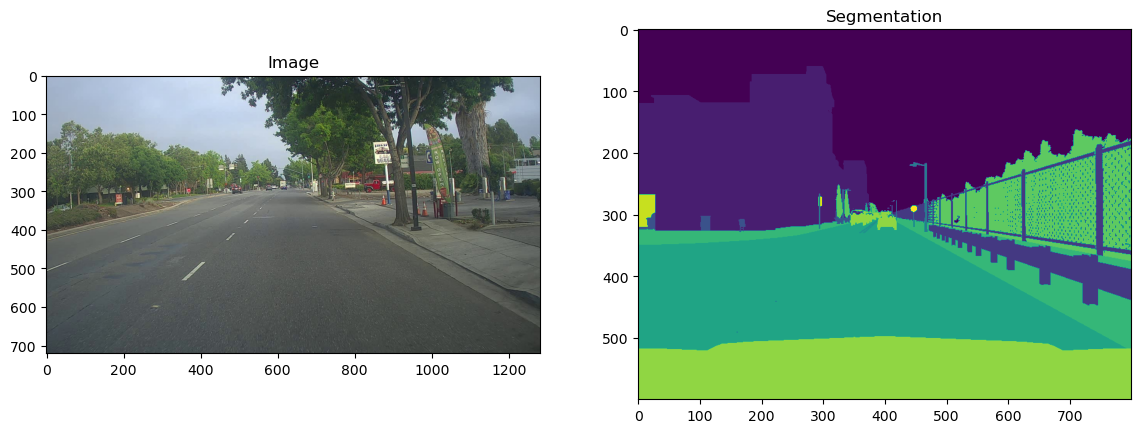

In [10]:
N = 3 #you can choose other index of image and mask
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10)) 
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

#What are the dimension of the images and masks
print(img.shape)
print(mask.shape)

<a name='2-1'></a>
### 2.1 - Create tf Dataset of Unmasked and Masked Images

In [11]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/yolo-traffic-object-detection/images/images/0001.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/cameramask/data/CameraMask/02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/yolo-traffic-object-detection/images/images/0002.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/cameramask/data/CameraMask/02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/yolo-traffic-object-detection/images/images/0003.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/cameramask/data/CameraMask/02_00_010.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)


dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)
    

<a name='2-2'></a>
### 2.2 - Data Preprocessing

In [ ]:
#Transform from png image to 3D matrix of real numbers
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)


## 3 - U-Net 

U-Net, named for its U-shape, was originally created in 2015 for medical image segmentation (tumor detection), but become a popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network (FCN), which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. 

U-Net uses equal number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information. 

<a name='3-1'></a>
### 3.1 - Model Details

<img src="https://github.com/renanaferreira/CAA-repository/blob/main/Lab9/images/unet.png?raw=true" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.
The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 transposed convolution, that halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total. 

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

<img src="https://github.com/renanaferreira/CAA-repository/blob/main/Lab9/images/encoder.png?raw=true" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks.

<a name='ex-1'></a>
### Ex. 1 - conv_block

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

Implement `conv_block(...)`: 

* Add 2 **Conv2D** layers with `n_filters` filters with `kernel_size` set to 3, `kernel_initializer` set to ['he_normal'](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), `padding` set to 'same' and 'relu' activation.

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial 
        # dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection 
        # outputs
    """

    # Add the first Conv2D layer
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    
    # Add the second Conv2D layer with the same parameters 
    conv = ?
    
# if dropout_prob > 0 add Dropout layer, with dropout_prob as parameter
    if dropout_prob > 0:
          conv = ?      
        
    # if max_pooling is True add MaxPooling2D with 2x2 pool_size & strides =2
    if max_pooling:
        next_layer = ?
         
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
# Test how to create a model with 1 conv_block

input_size=(96, 128, 3)
n_filters = 32

# function Input is applied to create 3D tensor shape of the inpit 
# required by the model

inputs = Input(input_size)

cblock1 = conv_block(inputs, n_filters)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

print(' Encoder (Downsampling Block) :')
for layer in summary(model1):
    print(layer)  
    
# What is the meaning of the printed numbers ?


<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="https://github.com/renanaferreira/CAA-repository/blob/main/Lab9/images/decoder.png?raw=true" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

`Conv2DTranspose` layer performs the inverse of the `Conv2D` layer. Read more about it [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)


<a name='ex-2'></a>
### Ex. 2 - upsampling_block

Function `upsampling_block(...)`:

* Takes the arguments `expansive_input` (which is the input tensor from the previous layer) and `contractive_input` (the input tensor from the previous skip layer)
* The number of filters here is the same as in the downsampling block you completed.
* `Conv2DTranspose` layer will take `n_filters` with shape (3,3) and a stride of (2,2), with padding set to `same`. It's applied to `expansive_input`, or the input tensor from the previous layer. 

This block is also where the outputs from the encoder blocks are concatenated, creating skip connections. 

* Concatenate `Conv2DTranspose` layer output to the contractive input, with `axis`= 3. In general, you can concatenate the tensors in the order that you prefer. Here it is suggested to use `[up, contractive_input]`

* For the final component, set the parameters for two Conv2D layers to the same values that you set for the two Conv2D layers in the encoder (ReLU activation, He normal initializer, `same` padding). 


In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    #Add Conv2DTranspose layer with n_filters with kernel size 3
    #and a stride of (2,2), with padding set to same. 
    #It's applied to expansive_input 
    
    up = ?
    
    #Concatenate Conv2DTranspose layer output (up) and 
    # the contractive input, axis = 3. 
    merge = ?
    
# Add 2 Conv2D layers with the same parameters as 2 Conv2D layers
# in the encoder (ReLU activation, He normal initializer, same padding).
    conv = ?
    
    conv = ?
    
    
    return conv

In [ ]:
# Test how to create a model with 1 upsampling_block
# as it was done with the conv_block
exp_input_size=(12, 16, 256)
contr_input_size = (24, 32, 128)
n_filters = 32

#Apply function Input to create 3D tensor shape of the 2 inputs
# (expansive_input, contractive_input) of upsampling_block

expansive_inputs = ?
contractive_inputs = ?


cblock2 = ?

# Argument inputs =[expansive_inputs, contractive_inputs]
model2 = ?

print(' Decoder (Upsampling Block: ?')
 ?

<a name='3-4'></a>
### 3.4 - Build the Model

Now you will put it all together - the encoder, bottleneck, and decoder. 

<a name='ex-3'></a>
### Ex. 3 - unet_model

For the function `unet_model`, specify the input shape, number of filters, and number of classes (23 in this case). The number of classes is equal to the number of output channels - there are 23 possible labels for each pixel in this self-driving car dataset. 

For the first half of the model:

* Begin with a conv block that takes the inputs of the model and the number of filters
* Then, chain the first output element of each block to the input of the next convolutional block
* Next, double the number of filters at each step
* For  `block4` add `dropout` of 0.3
* For the final conv_block (`block5`), set `dropout` to 0.3, turn off max pooling. (Here `n_filters=n_filters* 16`)

For the second half:
* From here, at each step, use half the number of filters of the previous block
* Use cblock5 as expansive_input and cblock4 as contractive_input, with `n_filters` * 8. This is the bottleneck layer. 
* Chain the output of the previous block as expansive_input and the corresponding contractive block output.
* Note that you must use the second element of the contractive block before the max pooling layer. 
* `conv9` is a Conv2D layer with ReLU activation, He normal initializer, `same` padding
* Finally, `conv10` is a Conv2D that takes the number of classes as the filter, a kernel size of 1, and "same" padding. The output of `conv10` is the output of your model. 

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    
# PART 1: Contracting Path (ENCODING)

# Add conv_block with the inputs of the unet_ model and n_filters
    cblock1 = ?
    
# The first element of the output of each block has to be the input 
# of the next conv_block. Double the # of filters at each next step. 
        cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    
# Add conv_block; double the # of filters compared to the previous block 
    cblock3 = ?
    
# Add conv_block; double the # of filters; include dropout of 0.3 
    cblock4 = ?
    
# Add conv_block; double the # of filters; include dropout of 0.3;    
# max_pooling=False
    cblock5 = ?
    
    
# PART 2: Expanding Path (DECODING)
# From here,at each step, use 1/2 the # of filters of the previous block 

# Add the 1st upsampling_block. Use cblock5[0] as expansive_input,
# cblock4[1] as contractive_input and n_filters * 8
    
    ublock6 = ?
    
# Chain the output of the previous block as expansive_input and the 
# 2nd output of the contractive block (skip connection) as contractive input.
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    
    ublock8 = ?
    
    ublock9 = ?
    
#Add Conv2D layer with ReLU activation, he_normal initializer;`same` padding
    conv9 = 

# Add Conv2D layer with n_classes filters, kernel size 1; 'same' padding

    conv10 = 
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
# Get the model summary
# How many trainable parameters has the model ?
?

### 3.5 - Loss Function

*Sparse categorical crossentropy* is more efficient than other loss functions when performing pixel-wise multiclass prediction.

In [ ]:
unet.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 4 - Train the Model  (It is a very slow process !!!) 

In [ ]:
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Fit the model over 5 epochs
# With 40 epochs you may get very good results but it may take hours.

model_history = ?


In [ ]:
# Plot the history of Model Accuracy over the iterations

?

###  Create Predicted Masks 

This function uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

### Show Predictions 

Check the predicted masks against the true mask and the original image.

In [ ]:
for image, mask in train_dataset.take(3):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])

<font color='blue'>
    
**What you should remember**: 

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net